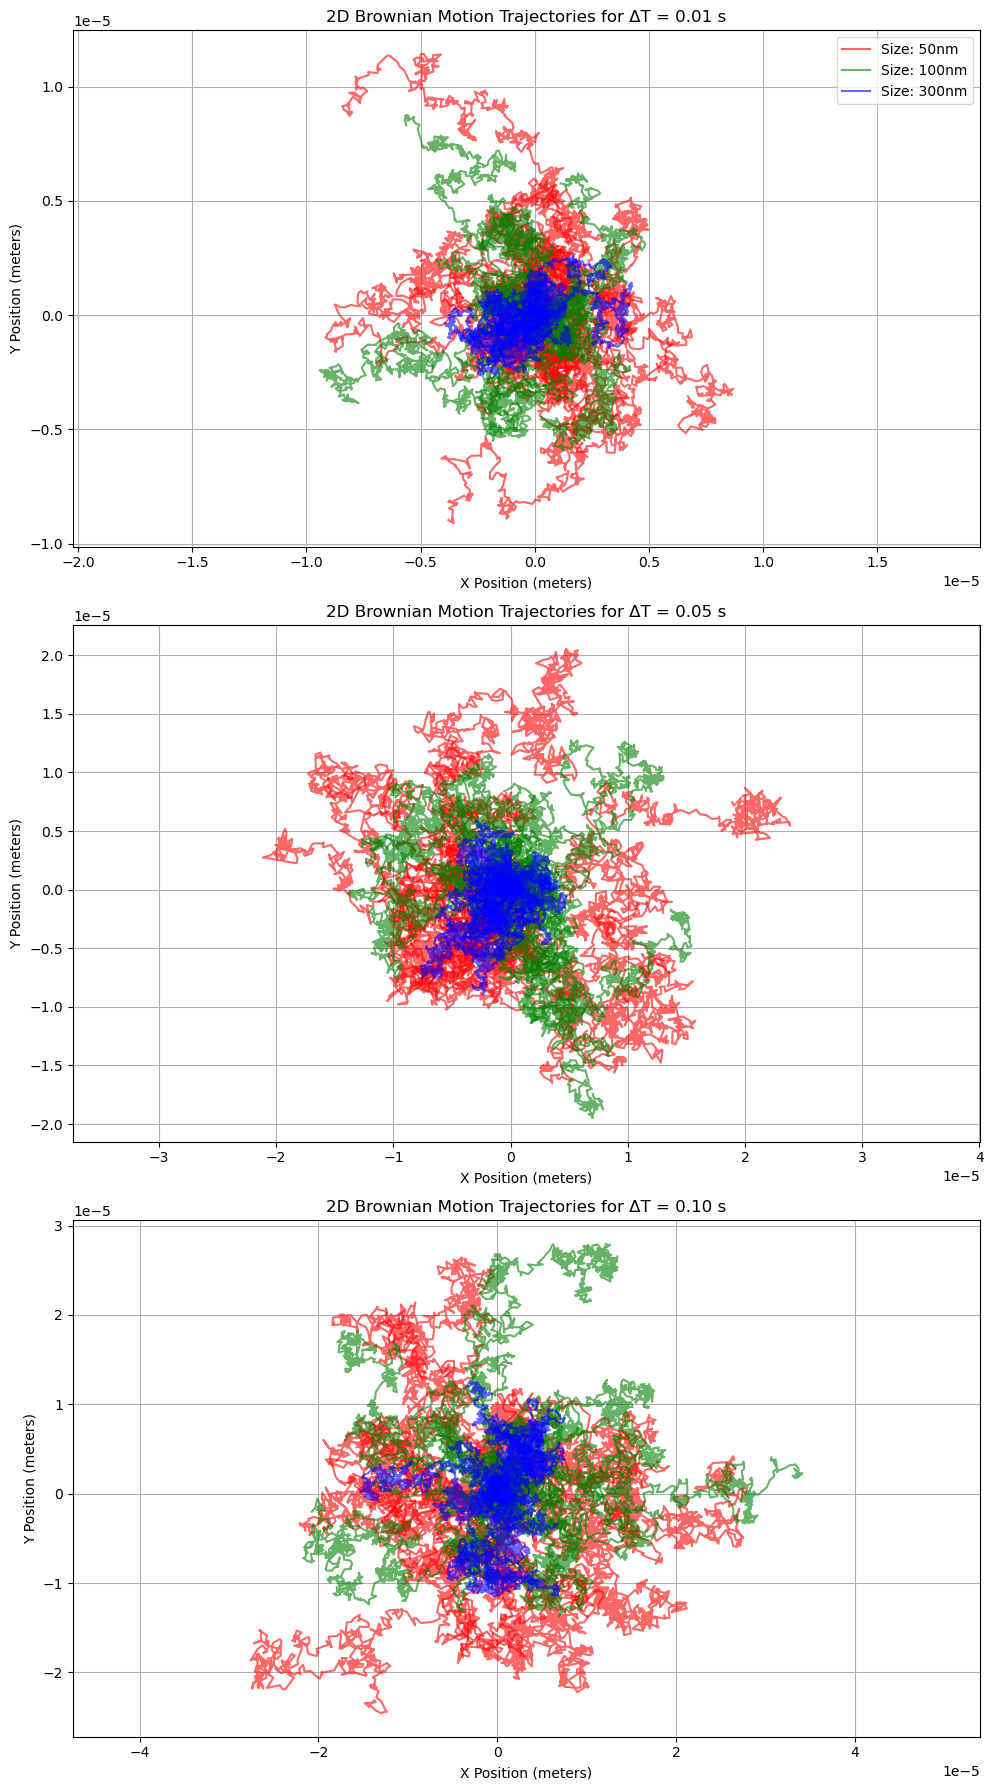

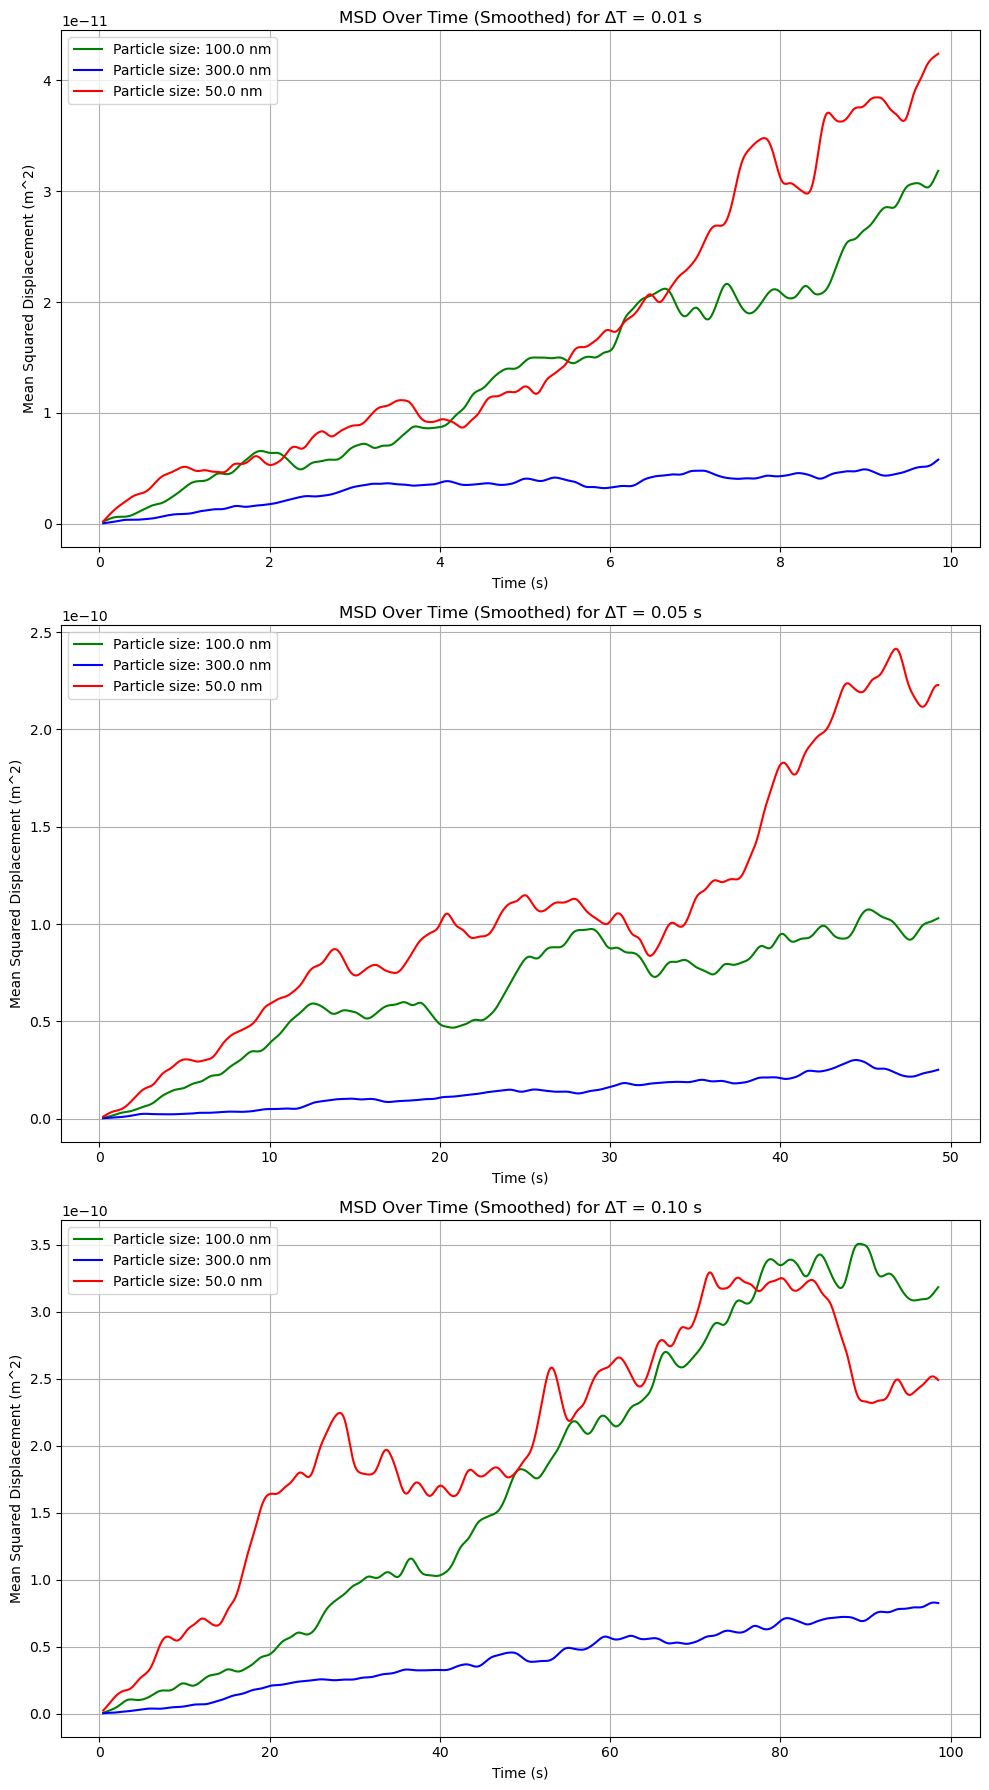

In [10]:
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt

# Specify the folder where your CSV files are located
folder_path = r"D:/Thesis_Workspace/Main_Cplusplus/brownian_v1.5" # /mnt/d/Thesis_Workspace/Main_C++/brownian_v1.2

#############################################
# 1. Plot Trajectories (Grouped by ΔT)      #
#############################################

# Create a search pattern to match trajectory CSV files
traj_pattern = os.path.join(folder_path, "traj_dt*_size*.csv")
traj_csv_files = glob.glob(traj_pattern)

if not traj_csv_files:
    print("No trajectory CSV files found in:", folder_path)
else:
    # Group files by the dt (time interval) value extracted from the file name.
    # Each key in dt_groups is the dt value as a string,
    # and each value is a list of tuples: (size, file_path)
    dt_groups = {}
    for csv_file in traj_csv_files:
        basename = os.path.basename(csv_file)         # e.g., "traj_dt0.01_size50nm.csv"
        base_no_ext = os.path.splitext(basename)[0]      # e.g., "traj_dt0.01_size50nm"
        if base_no_ext.startswith("traj_dt"):
            remainder = base_no_ext[len("traj_dt"):]     # e.g., "0.01_size50nm"
            parts = remainder.split("_")
            if len(parts) >= 2:
                dt_val = parts[0]  # e.g., "0.01"
                size_str = None
                for part in parts[1:]:
                    if part.startswith("size"):
                        size_str = part[4:]  # Remove the "size" prefix → "50nm", etc.
                        break
                if dt_val not in dt_groups:
                    dt_groups[dt_val] = []
                dt_groups[dt_val].append((size_str, csv_file))
    
    # Define a mapping from particle size to a color
    size_color = {
        "50nm": "red",
        "100nm": "green",
        "300nm": "blue"
    }
    
    # Sort dt groups by dt value (as a float) to ensure logical order.
    dt_keys = sorted(dt_groups.keys(), key=lambda x: float(x))
    n_subplots = len(dt_keys)
    fig_traj, axes_traj = plt.subplots(n_subplots, 1, figsize=(10, 6 * n_subplots))
    # If only one subplot, wrap it in a list for uniformity.
    if n_subplots == 1:
        axes_traj = [axes_traj]
    
    # Iterate over each dt group and plot its trajectories on a separate subplot.
    for index, dt_val in enumerate(dt_keys):
        ax_traj = axes_traj[index]
        
        # Sort the sizes to control layering order: 50nm → 100nm → 300nm
        sorted_sizes = ["50nm", "100nm", "300nm"]
        ordered_files = sorted(dt_groups[dt_val], key=lambda x: sorted_sizes.index(x[0]))
        
        for size_str, file_path in ordered_files:
            # Get the color for this size; default to black if not found.
            color = size_color.get(size_str, "black")
            
            # Read the CSV file into a DataFrame
            df = pd.read_csv(file_path)
            
            # Get the list of unique particles (assuming there is a "particle" column)
            particles = df["particle"].unique()
            
            # Plot each particle's trajectory.
            # Only label the first particle from each file to avoid duplicate legend entries.
            for i, p in enumerate(particles):
                particle_data = df[df["particle"] == p]
                label = f"Size: {size_str}" if i == 0 else ""
                ax_traj.plot(particle_data["x"], particle_data["y"],
                             color=color, alpha=0.6, label=label)
        
        ax_traj.set_xlabel("X Position (meters)")
        ax_traj.set_ylabel("Y Position (meters)")
        ax_traj.set_title(f"2D Brownian Motion Trajectories for ΔT = {float(dt_val):.2f} s")
        ax_traj.axis('equal')  # Ensure equal aspect ratio
        ax_traj.grid(True)
        # Optionally, add a legend only to the first subplot.
        if index == 0:
            ax_traj.legend()
    
    fig_traj.tight_layout()

#############################################
# 2. Plot MSD Line Charts (Grouped by ΔT)    #
#############################################

# Create a search pattern to match MSD CSV files
msd_pattern = os.path.join(folder_path, "msd_dt*_size*.csv")
msd_files = glob.glob(msd_pattern)

if not msd_files:
    print("No MSD CSV files found in:", folder_path)
else:
    # Group MSD files by the dt (time interval) value extracted from the file name.
    msd_dt_groups = {}
    for msd_file in msd_files:
        basename = os.path.basename(msd_file)         # e.g., "msd_dt0.01_size50nm.csv"
        base_no_ext = os.path.splitext(basename)[0]      # e.g., "msd_dt0.01_size50nm"
        if base_no_ext.startswith("msd_dt"):
            remainder = base_no_ext[len("msd_dt"):]      # e.g., "0.01_size50nm"
            parts = remainder.split("_")
            if len(parts) >= 2:
                dt_val = parts[0]  # e.g., "0.01"
                size_str = None
                for part in parts[1:]:
                    if part.startswith("size"):
                        size_str = part[4:]  # e.g., "50nm"
                        break
                if dt_val not in msd_dt_groups:
                    msd_dt_groups[dt_val] = []
                msd_dt_groups[dt_val].append((size_str, msd_file))
    
    # Sort the MSD dt groups by dt value (as a float)
    msd_dt_keys = sorted(msd_dt_groups.keys(), key=lambda x: float(x))
    n_msd_plots = len(msd_dt_keys)
    fig_msd, axes_msd = plt.subplots(n_msd_plots, 1, figsize=(10, 6 * n_msd_plots))
    if n_msd_plots == 1:
        axes_msd = [axes_msd]
    
    # # A Simple Moving Average (SMA) smoothing function
    # def smooth_data(series, window=5):
    #     return series.rolling(window=window).mean()
    
    # Cascading Moving Average for extra smoothness
    def smooth_data(series, window=10, iterations=3):  # More iterations = more smoothness
        for _ in range(iterations):
            series = series.rolling(window=window).mean().bfill()
        return series
    
    # Iterate over each dt group for the MSD files.
    for index, dt_val in enumerate(msd_dt_keys):
        ax_msd = axes_msd[index]
        for size_str, msd_file in msd_dt_groups[dt_val]:
            # Read the MSD CSV file into a DataFrame.
            df_msd = pd.read_csv(msd_file)
            # Apply smoothing to the 'time' and 'msd' columns.
            df_msd['smoothed_time'] = smooth_data(df_msd['time'])
            df_msd['smoothed_msd'] = smooth_data(df_msd['msd'])
            
            # Get the color for this particle size.
            color = size_color.get(size_str, "black")
            # Plot the smoothed MSD data.
            ax_msd.plot(df_msd['smoothed_time'], df_msd['smoothed_msd'],
                        label=f"Particle size: {float(size_str.replace('nm','')):.1f} nm",
                        color=color)
        
        ax_msd.set_xlabel("Time (s)")
        ax_msd.set_ylabel("Mean Squared Displacement (m^2)")
        ax_msd.set_title(f"MSD Over Time (Smoothed) for ΔT = {float(dt_val):.2f} s")
        ax_msd.grid(True)
        ax_msd.legend()
    
    fig_msd.tight_layout()

# Finally, display all figures.
plt.show()
